In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
import h5py

pd.set_option('max_colwidth', 400)

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Load some of our own functions
* A `setup.py` is added to have easier access to our functions
* Under `overcast` root directory, run `pip install -e .` . 
* ***RESTART*** the kernel of this notebook, then you are good to go.


In [3]:
from overcast import readers as rd
from overcast.utils import fn2rgt, datainfo, query_rgt, box_sel

## Archive all the data we have a region
* Find all the files for each product
* put the RGT, cycle_number, and filename into Pandas DataFrame so we can match granules. This is done by calling `datainfo` in `utils.py`.

In [4]:
ROI = 'BEAUFORT' ## ['LAPTEV','CHUKCHI']
dataroot = Path.home()/'shared/data-overcast'/ROI

fns07 = sorted( (dataroot/'ATL07').glob('*.h5') )
fns09 = sorted( (dataroot/'ATL09').glob('*.h5') )
db07 = datainfo(fns07)
db09 = datainfo(fns09)
db07.head()

,rgt,cycle_number,filename
0,1112,3,/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190610013526_11120301_003_02.h5
1,1119,3,/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190610123527_11190301_003_02.h5
2,1127,3,/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190611010946_11270301_003_02.h5
3,1134,3,/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190611120948_11340301_003_02.h5
4,1142,3,/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190612004407_11420301_003_02.h5


## Select a granule and find the files from ATL07 and ATL09 database
* This uses a simple function `query_rgt` in `utils.py`

In [5]:
rgt = 1112; cyc = 3

fn07 = query_rgt(rgt,cyc,db07)[0]
fn09 = query_rgt(rgt,cyc,db09)[0]
print(fn07)
print(fn09)

/home/jovyan/shared/data-overcast/BEAUFORT/ATL07/processed_ATL07-01_20190610013526_11120301_003_02.h5
/home/jovyan/shared/data-overcast/BEAUFORT/ATL09/processed_ATL09_20190610013526_11120301_003_01.h5


## Check space orientation. 
* ATL09 is strong beam only so we have to find the matching ATL07 beam
* Choose the center beam for example

In [8]:
f07 = h5py.File(fn07, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f07['orbit_info/sc_orient'][0])
f07.close()

0


In [9]:
beam07 = 'gt2l'
beam09 = 'profile_2'

## Read ATL07 and ATL09 data
* For ATL07, the reader from the sea ice tutorial is used.
* A `getATL09` reader is added to `readers.py` but using xarray because we want to include some 2D data.
* Another advantage of xarray dataset is that now we can add attributes to variables.

In [10]:
with h5py.File(fn07, 'r') as f07:
    df07= rd.getATL07(f07,beam07)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,79.993890,-136.370156,3.402823e+38,4.536729e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-1.535560,0.022797,-0.019312,-0.075182
1,79.993890,-136.370156,3.402823e+38,4.536729e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-1.535560,0.022797,-0.019312,-0.075182
2,79.993890,-136.370156,3.402823e+38,4.536729e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-1.535560,0.022797,-0.019312,-0.075182
3,79.990759,-136.374049,3.402823e+38,4.536729e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-1.543683,0.022812,-0.019311,-0.075201
4,79.988316,-136.377089,3.402823e+38,4.536729e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-1.550053,0.022823,-0.019311,-0.075235


In [11]:
with h5py.File(fn09, 'r') as f09:
    ds09= rd.getATL09(f09,beam09)
ds09

<xarray.Dataset>
Dimensions:           (dt: 1608, nbin: 700, nlay: 10, zbin: 700)
Coordinates:
  * dt                (dt) float64 4.537e+07 4.537e+07 ... 4.537e+07 4.537e+07
  * nlay              (nlay) int32 1 2 3 4 5 6 7 8 9 10
  * zbin              (zbin) float32 20000.0 19970.021 ... -925.5137 -955.4922
Dimensions without coordinates: nbin
Data variables:
    lats              (dt) float64 80.0 80.0 79.99 79.99 ... 75.99 75.98 75.98
    lons              (dt) float64 -136.4 -136.4 -136.4 ... -140.0 -140.0 -140.0
    prof_dist_x       (dt) float64 1.113e+07 1.113e+07 ... 1.159e+07 1.159e+07
    prof_dist_y       (dt) float32 20.736574 20.791199 ... 22.475702 22.624264
    cloud_flag_asr    (dt) int8 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 4 3 3 2 3 4 3 2
    cloud_fold_flag   (dt) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    column_od_asr     (dt) float32 3.4028235e+38 3.4028235e+38 ... 0.05743288
    column_od_asr_qf  (dt) int8 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2 2
    layer_flag        (dt) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 1 0 0 0 0 1 0 0
    msw_flag          (dt) int8 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3
    bsnow_h           (dt) float32 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38
    bsnow_od          (dt) float32 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38
    bsnow_con         (dt) int8 -3 -3 -3 -3 -3 -3 -3 -3 ... -2 -2 -2 -2 -2 -2 -2
    bsnow_psc         (dt) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    layer_bot         (dt, nlay) float32 813.2832 ... 3.4028235e+38
    layer_top         (dt, nlay) float32 1083.0957 ... 3.4028235e+38
    layer_attr        (dt, nlay) int8 1 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    layer_con         (dt, nlay) int32 76 2147483647 ... 2147483647 2147483647
    layer_ib          (dt, nlay) float32 0.033215918 ... 3.4028235e+38
    cab_prof          (dt, nbin) float32 3.4028235e+38 ... 3.4028235e+38

## Select a region we want to plot
* Here we used the same bounding box as we used yesterday
* both ATL07 and ATL09 data are selected by calling the same function `box_sel` in `utils.py`. 
* Check `ds09_cut` and `df07_cut` to make sure they are in our box

In [12]:
bbox = [-150,75,-110,78]
df07_cut=df07[box_sel(df07,bbox)]
ds09_cut=ds09.where(box_sel(ds09,bbox),drop=True)

In [13]:
ds09_cut

<xarray.Dataset>
Dimensions:           (dt: 806, nbin: 700, nlay: 10, zbin: 700)
Coordinates:
  * dt                (dt) float64 4.537e+07 4.537e+07 ... 4.537e+07 4.537e+07
  * nlay              (nlay) int32 1 2 3 4 5 6 7 8 9 10
  * zbin              (zbin) float32 20000.0 19970.021 ... -925.5137 -955.4922
Dimensions without coordinates: nbin
Data variables:
    lats              (dt) float64 78.0 78.0 77.99 77.99 ... 75.99 75.98 75.98
    lons              (dt) float64 -138.5 -138.5 -138.5 ... -140.0 -140.0 -140.0
    prof_dist_x       (dt) float64 1.136e+07 1.136e+07 ... 1.159e+07 1.159e+07
    prof_dist_y       (dt) float32 31.409124 31.146385 ... 22.475702 22.624264
    cloud_flag_asr    (dt) float64 5.0 5.0 5.0 5.0 5.0 ... 2.0 3.0 4.0 3.0 2.0
    cloud_fold_flag   (dt) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    column_od_asr     (dt) float32 3.4028235e+38 3.4028235e+38 ... 0.05743288
    column_od_asr_qf  (dt) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0 2.0
    layer_flag        (dt) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 1.0 0.0 0.0
    msw_flag          (dt) float64 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
    bsnow_h           (dt) float32 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38
    bsnow_od          (dt) float32 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38
    bsnow_con         (dt) float64 -3.0 -3.0 -3.0 -3.0 ... -2.0 -2.0 -2.0 -2.0
    bsnow_psc         (dt) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    layer_bot         (dt, nlay) float32 543.46875 ... 3.4028235e+38
    layer_top         (dt, nlay) float32 813.2832 ... 3.4028235e+38
    layer_attr        (dt, nlay) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    layer_con         (dt, nlay) float64 56.0 2.147e+09 ... 2.147e+09 2.147e+09
    layer_ib          (dt, nlay) float32 0.025164278 ... 3.4028235e+38
    cab_prof          (dt, nbin) float32 3.4028235e+38 ... 3.4028235e+38

In [11]:
df07_cut

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
106,77.949628,-138.498417,3.402823e+38,4.536733e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-5.691957,0.030770,-0.018909,-0.094505
107,77.949628,-138.498417,3.402823e+38,4.536733e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-5.691957,0.030770,-0.018909,-0.094505
108,77.901922,-138.540050,3.402823e+38,4.536733e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-5.782588,0.030985,-0.018899,-0.094825
109,77.901922,-138.540050,3.402823e+38,4.536733e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-5.782588,0.030985,-0.018899,-0.094825
110,77.901314,-138.540581,3.402823e+38,4.536733e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,-5.783790,0.030988,-0.018899,-0.094826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7971,75.979862,-139.999773,4.445776e-01,4.536736e+07,1.597560e-02,1,0,1.970000e-01,5.000000e+00,2,-7.125599,0.036582,-0.018454,-0.104679
7972,75.979782,-139.999827,6.459848e-01,4.536736e+07,1.000984e-02,1,0,2.940000e-01,4.607143e+00,2,-7.125606,0.036582,-0.018454,-0.104679
7973,75.979709,-139.999876,6.871387e-01,4.536736e+07,1.213117e-02,1,0,2.620000e-01,5.360000e+00,2,-7.125617,0.036583,-0.018454,-0.104679
7974,75.979635,-139.999926,5.574636e-01,4.536736e+07,1.809469e-02,1,0,1.670000e-01,5.400000e+00,2,-7.125645,0.036583,-0.018454,-0.104679


## Get the clout top and bottom height from ATL09
* This is a simple case, where only one layer of cloud is present
* At this time of year, no blowing snow either.

In [14]:
laytop = ds09_cut['layer_top'].values
laytop[laytop>20e3] = -100
ctop = laytop.max(axis=1)
laybot = ds09_cut['layer_bot'].values
cbot = laybot.min(axis=1)

## First plot in a map to see where the granule is 

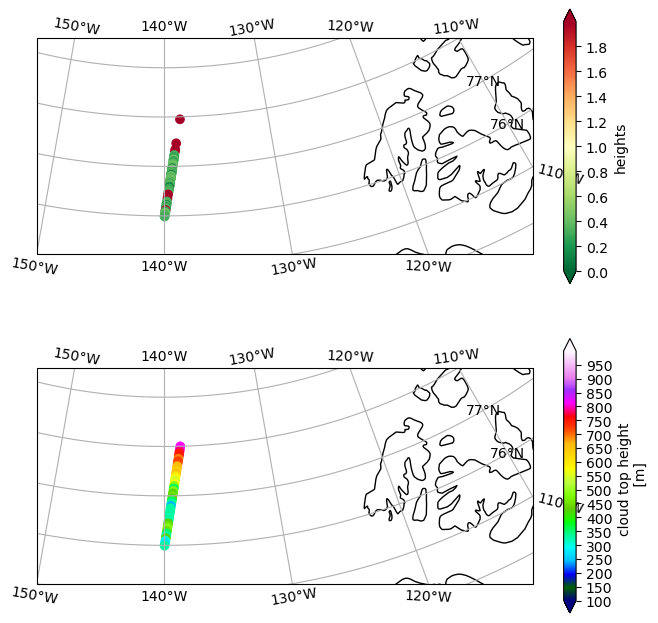

In [15]:
bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
pcproj   = ccrs.PlateCarree()

var = 'heights'
vmin = 0; vmax= 2
ticks=np.arange(vmin,vmax,.2)
fig = plt.figure(1,figsize=(8,8),dpi=100)
ax1 = fig.add_subplot(211,projection=bea_proj)
ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
ax1.gridlines(draw_labels=True)
hdl = plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], 
            cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
            vmin=vmin,vmax=vmax,
            transform=pcproj)
plt.colorbar(label=var, shrink=1, ticks=ticks,extend='both');

ax2 = fig.add_subplot(212,projection=bea_proj)
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
plt.scatter(ds09_cut['lons'][::20], ds09_cut['lats'][::20],c=ctop[::20], 
            cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
            vmin=100,vmax=1000,
            transform=pcproj)
plt.colorbar(label='cloud top height \n [m]', shrink=1, ticks=np.arange(100,1000,50),extend='both');

## Plot ATL07 and ATL09 data along the same latitude coordinate
* It seem the laser is totally attenuated near the right end of the plots so very little surface and column optical depth retrieval
* so it is likely cloud on the left and on the right are of different origin?

Text(0.5, 0, 'latitude')

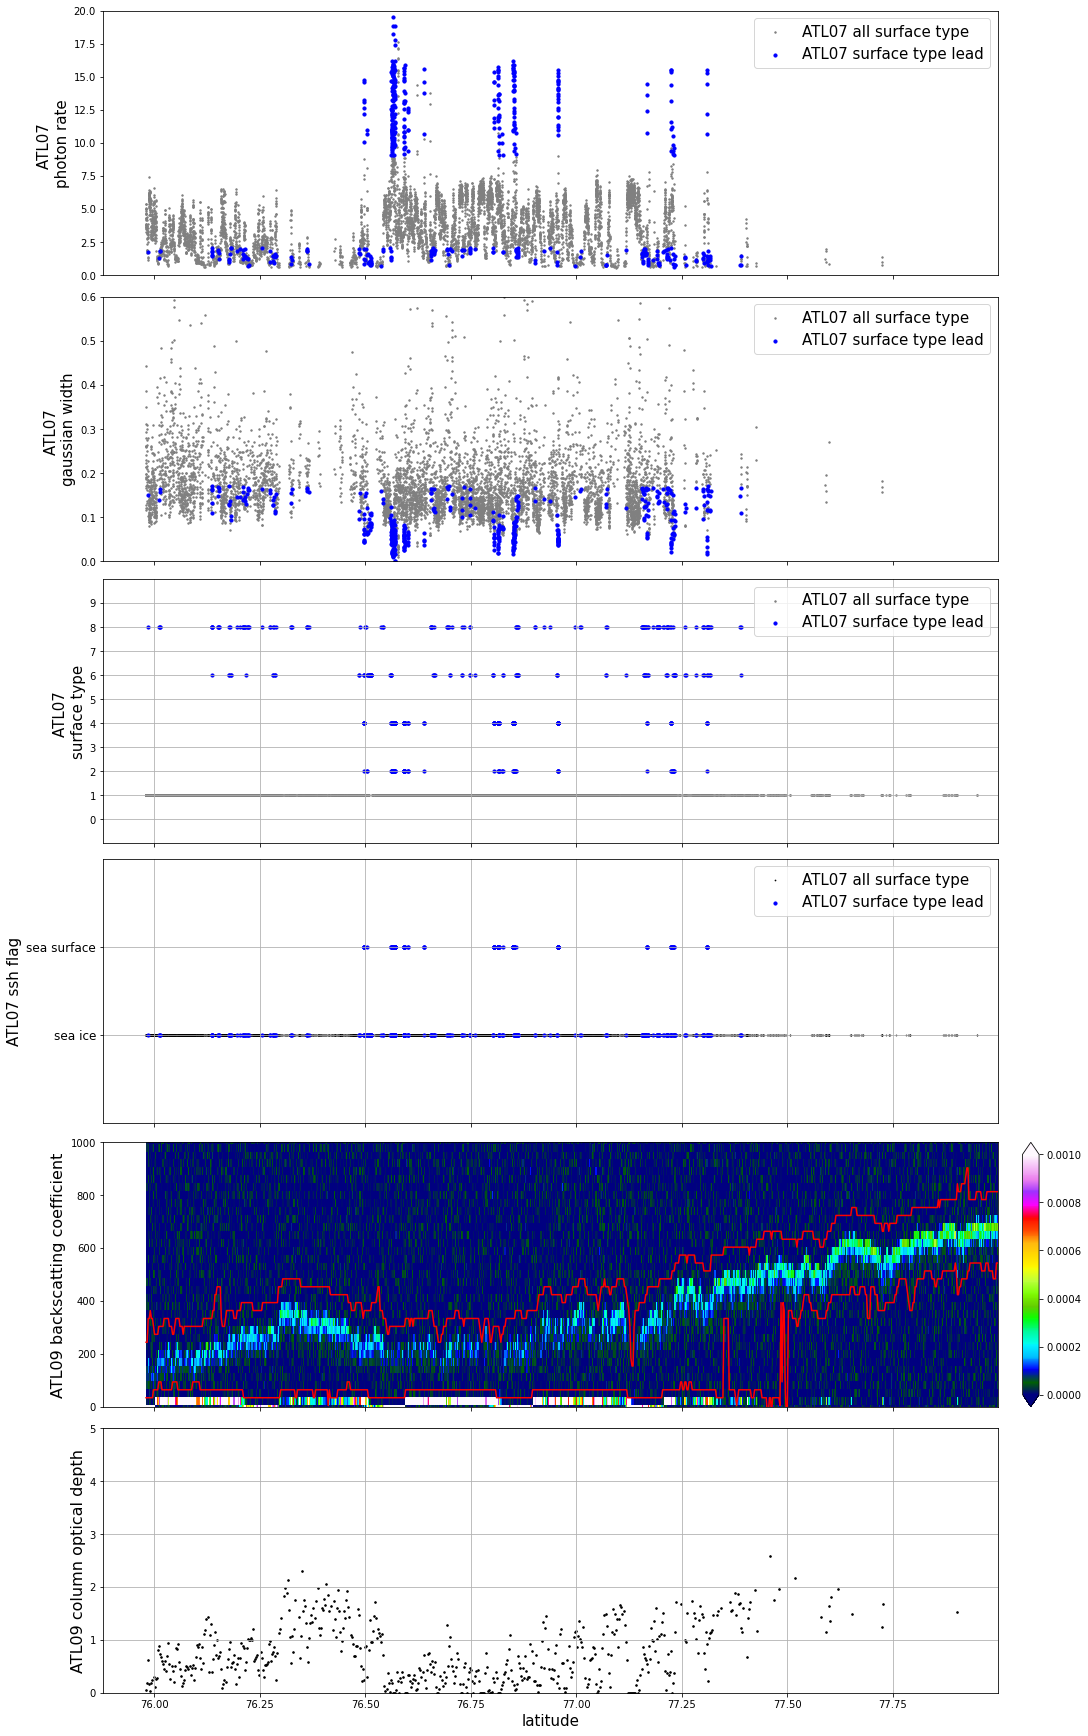

In [17]:
fig,ax=plt.subplots(6,1,figsize=(15,24),sharex=True,constrained_layout=True)

i = 0
ax[i].scatter(df07_cut.lats,df07_cut.photon_rate,s=2,c='gray', label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].photon_rate,s=10,c='b', label= 'ATL07 surface type lead')
ax[i].legend(fontsize=15)
ax[i].set_ylim(0,20)
ax[i].set_ylabel('ATL07 \nphoton rate',fontsize=15)

i+=1
ax[i].scatter(df07_cut.lats,df07_cut.gauss,s=2,c='gray', label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].gauss,s=10,c='blue',label= 'ATL07 surface type lead')
ax[i].legend(loc=1,fontsize=15)
ax[i].set_ylabel('ATL07 \ngaussian width',fontsize=15)
ax[i].set_ylim(0,.6)

i+=1
ax[i].grid()
ax[i].scatter(df07_cut.lats,df07_cut.stype,s=2,c='gray',label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].stype,s=10,c='blue',label= 'ATL07 surface type lead')
ax[i].legend(fontsize=15)
ax[i].set_ylim(-1,10)
ax[i].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[i].set_yticks(np.arange(0,10,1))

i+=1
ax[i].scatter(df07_cut.lats,df07_cut.ssh_flag,c='k',s=2,marker='.',label='ATL07 all surface type')
ax[i].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].ssh_flag,c='b',s=10,label='ATL07 surface type lead')
ax[i].legend(fontsize=15)
ax[i].grid()
ax[i].set_ylim(-1,2)
ax[i].set_yticks(np.arange(0,2,1))
ax[i].set_yticklabels(['sea ice', 'sea surface'],fontsize=12)
ax[i].set_ylabel('ATL07 ssh flag',fontsize=15)

i+=1
hdl = ax[i].pcolormesh(ds09_cut['lats'],ds09_cut['zbin'],ds09_cut['cab_prof'].T,
                      vmin=0,vmax=1e-3,
                      cmap=plt.cm.gist_ncar)
ax[i].set_ylim([0,1000])
cb = fig.colorbar(hdl, ax=ax[i],extend='both',aspect=10)
ax[i].plot(ds09_cut['lats'],ctop,'r')
ax[i].plot(ds09_cut['lats'],cbot,'r')
ax[i].set_ylabel('ATL09 backscatting coefficient',fontsize=16)

i+=1
ax[i].scatter(ds09_cut.lats,ds09_cut.column_od_asr,c='k',s=10,marker='.')
ax[i].set_ylabel('ATL09 column optical depth',fontsize=16)
ax[i].set_ylim([0,5])
ax[i].grid()


ax[i].set_xlabel('latitude',fontsize=15)

In [12]:
## Failed attempt to use widget 
# bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
# pcproj   = ccrs.PlateCarree()

# var = 'heights'
# vmin = 0; vmax= 2
# ticks=np.arange(vmin,vmax,.2)
# fig = plt.figure(1,figsize=(8,8),dpi=100)
# ax1 = fig.add_subplot(211,projection=bea_proj)
# ax1.coastlines(resolution='50m', color='black', linewidth=1)
# ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
# ax1.gridlines(draw_labels=True)
# plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], 
#             cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
#             vmin=vmin,vmax=vmax,
#             transform=pcproj)
# plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

# laytop = ds09_cut['layer_top'].values
# laytop[laytop>20e3] = -100
# ctop = laytop.max(axis=1)
# ax2 = fig.add_subplot(212,sharex=ax1,sharey=ax1,projection=bea_proj)
# ax2.coastlines(resolution='50m', color='black', linewidth=1)
# ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
# ax2.gridlines(draw_labels=True)
# plt.scatter(ds09_cut['lons'][::20], ds09_cut['lats'][::20],c=ctop[::20], 
#             cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
#             vmin=100,vmax=1000,
#             transform=pcproj)
# plt.colorbar(label='cloud top height', shrink=0.5, ticks=np.arange(100,1000,50),extend='both');